## Import libraries

In [6]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
# import dask.array as da
import dask.dataframe as dd
import pandas as pd

# Libraries to detect important features
from sklearn.ensemble import RandomForestClassifier as RF

# Libraries to visualize data
import matplotlib.pyplot as plt

# Libraries for monitoring operation process
from tqdm import tqdm

## Configurate and declare global variables

In [7]:
os_name = os.name

if os_name == 'nt':
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886

%matplotlib inline

## Import data

In [8]:
# Load document embeddings of skill concatenating in numpy format file
skill_concat_zip = np.load(OUTPUT_DIR + "skill_wide_embeddings.npz")
skill_concat_embeddings = skill_concat_zip['skill_wide_embeddings']

In [9]:
# skill_wide_embeddings = da.from_array(skill_concat_embeddings)

In [10]:
skill_concat_embeddings_df = pd.DataFrame(skill_concat_embeddings)
skill_concat_embeddings_df.shape

(361584, 900)

In [11]:
skill_concat_embeddings_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,-0.101796,0.363078,0.042792,-0.489065,0.122118,0.173836,0.047916,-0.207800,-0.026969,1.656225,...,-0.280528,0.080700,0.09417,-0.137940,0.104393,-0.234298,-0.127686,0.056547,-0.124596,0.211194
1,-0.257782,0.178756,-0.144927,0.017641,0.015550,0.263644,0.162037,-0.180790,0.029007,2.332600,...,-0.369034,-0.101637,0.06639,0.368735,-0.241632,-0.265535,0.302495,-0.222885,0.080753,0.009460
2,-0.222878,-0.007662,0.269970,-0.097579,-0.243062,0.005437,0.131355,-0.084797,0.086806,2.879733,...,-0.281284,0.016800,-0.04405,0.152550,-0.098808,-0.323907,-0.126676,-0.166446,0.309133,0.003908


## Detect important features

In [12]:
# def create_synthetic_data(X, seed=6886):
#     """
#     Creates synthetic data
#     :param X: data needed to create synthetic data
#     :param seed: seed to fix numpy random function
#     :return: synthetic data made from X
#     """
#     nof_objects = X.shape[0]
#     nof_features = X.shape[1]
#     da.random.seed(seed)

#     synthetic_X = da.zeros(X.shape)

#     pbar = tqdm(desc="Creating synthetic data", total=len(range(nof_features)))
#     for f in range(nof_features):
#         feature_values = X[:, f]
#         synthetic_X[:, f] += da.random.choice(feature_values, nof_objects)
#         feature_values = None
#         pbar.update(1)
#     pbar.close()

#     synthetic_Y = da.zeros(nof_objects)
# #     X_total = da.concatenate([X, synthetic_X])
# #     Y_total = da.concatenate(
# #         [
# #             da.zeros(nof_objects),
# #             da.ones(nof_objects),
# #         ]
# #     )

# #     return X_total, Y_total
#     return synthetic_X, synthetic_Y

In [13]:
# Create new dataset including synthetic data
# X_total, Y_total = create_synthetic_data(skill_wide_embeddings, seed=SEED)
# X_synthetic, Y_synthetic = create_synthetic_data(skill_wide_embeddings, seed=SEED)

In [14]:
# Create synthetic data
np.random.seed(SEED)
tqdm.pandas(desc="Creating synthetic data")
X_synthetic = skill_concat_embeddings_df.progress_apply(np.random.permutation, axis=0)

Creating synthetic data: 100%|███████████████████████████████████████████████████████| 900/900 [00:32<00:00, 27.72it/s]


In [15]:
X_synthetic.shape

(361584, 900)

In [16]:
X_synthetic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.000000,0.00000,0.437755,0.00000,0.00000,0.0,0.0,-0.204347,0.071551,0.0000,...,0.000000,0.000000,0.022705,0.022000,-0.261864,0.145511,0.306658,-0.27167,-0.268533,0.283195
1,0.000000,0.19675,0.242350,-0.13796,-0.07734,0.0,0.0,0.000000,0.001731,2.4043,...,-0.598605,0.051508,-0.015620,-0.306160,0.491760,-0.035411,0.281670,0.18763,0.097490,-0.051246
2,0.042484,0.00000,0.000000,0.00000,0.00000,0.0,0.0,0.000000,0.000000,1.8147,...,-0.297265,0.095316,-0.012835,0.085569,-0.148940,0.140822,-0.176300,0.45456,-0.002288,-0.014105


In [17]:
# Merge authentic and synthetic data
X_total = np.concatenate([skill_concat_embeddings_df, X_synthetic])
Y_total = np.concatenate(
    [
        np.ones(skill_concat_embeddings.shape[0]),
        np.zeros(skill_concat_embeddings.shape[0]),
    ]
)

In [18]:
X_total.shape, Y_total.shape

((723168, 900), (723168,))

In [19]:
desc_cols = ['desc_' + str(i) for i in range(300)]
req_cols = ['req_' + str(i) for i in range(300)]
qual_cols = ['qual_' + str(i) for i in range(300)]
token_cols = desc_cols + req_cols + qual_cols
len(token_cols), token_cols[295:305], token_cols[595:605]

(900,
 ['desc_295',
  'desc_296',
  'desc_297',
  'desc_298',
  'desc_299',
  'req_0',
  'req_1',
  'req_2',
  'req_3',
  'req_4'],
 ['req_295',
  'req_296',
  'req_297',
  'req_298',
  'req_299',
  'qual_0',
  'qual_1',
  'qual_2',
  'qual_3',
  'qual_4'])

In [23]:
# Save synthetic data and merged data to file
dd.to_parquet(
    dd.from_pandas(pd.DataFrame(X_total, columns=token_cols), npartitions=20),
    OUTPUT_DIR + "skill_synthetic_data/total/",
)

In [25]:
pd.DataFrame(Y_total).to_csv(
    OUTPUT_DIR + "skill_synthetic_data/Y_total.csv", index=False
)

In [22]:
dd.to_parquet(
    dd.from_pandas(X_synthetic, npartitions=10), OUTPUT_DIR + "skill_synthetic_data/synthetic/"
)

In [27]:
# Run random forest on new dataset
rf = RF(n_estimators=200, n_jobs=-1, random_state=SEED, verbose=2).fit(X_total, Y_total)
feat_importance = rf.feature_importances_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200
building tree 4 of 200

building tree 5 of 200
building tree 6 of 200building tree 7 of 200
building tree 8 of 200

building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.5min


building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 23.7min


building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 33.0min finished


In [54]:
# Create color based on columns
column_width = int(X_total.shape[1]/3)
colors = ['#009933']*column_width  # job_description
colors.extend(['#27aee1']*column_width)  # job_requirement
colors.extend(['#900c3f']*column_width)  # job_qualification
print(colors[290:330])

indices = np.argsort(feat_importance)
# print(indices[290:330])

colors = np.array(colors)[indices]
print(colors[290:330])

['#009933', '#009933', '#009933', '#009933', '#009933', '#009933', '#009933', '#009933', '#009933', '#009933', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1', '#27aee1']
['#27aee1' '#27aee1' '#27aee1' '#900c3f' '#009933' '#27aee1' '#900c3f'
 '#900c3f' '#27aee1' '#009933' '#009933' '#009933' '#27aee1' '#900c3f'
 '#900c3f' '#009933' '#27aee1' '#900c3f' '#27aee1' '#900c3f' '#009933'
 '#900c3f' '#900c3f' '#900c3f' '#27aee1' '#900c3f' '#009933' '#009933'
 '#900c3f' '#900c3f' '#27aee1' '#009933' '#27aee1' '#900c3f' '#27aee1'
 '#27aee1' '#900c3f' '#27aee1' '#27aee1' '#009933']


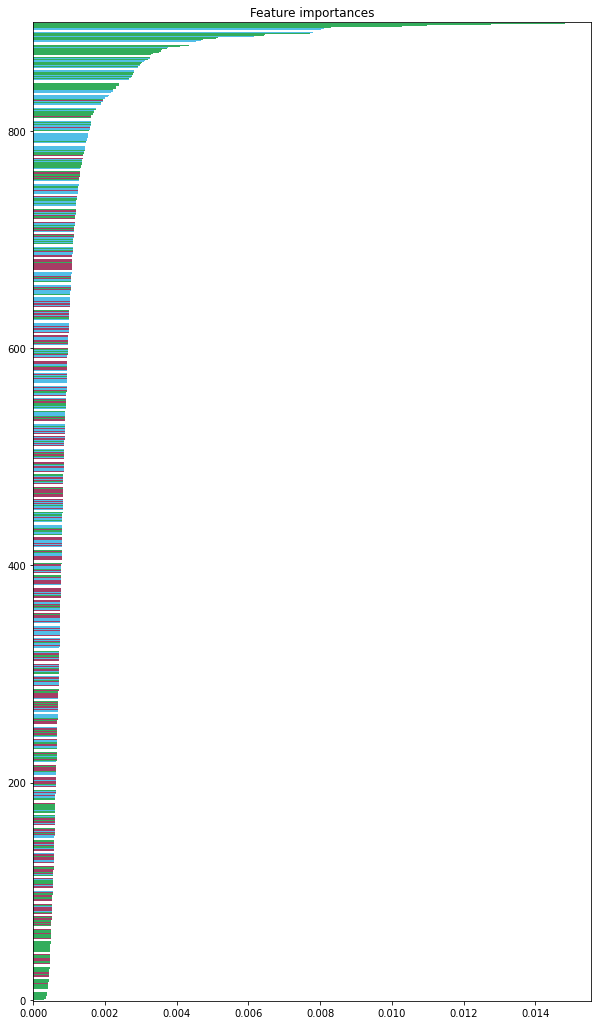

In [58]:
# Plot the feature importances of the forest
indices = np.argsort(feat_importance)

plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(X_total.shape[1]),
    feat_importance[indices],
    color=colors,
    align="center",
    alpha=0.8,
)
plt.ylim([-1, X_total.shape[1]])
plt.show()

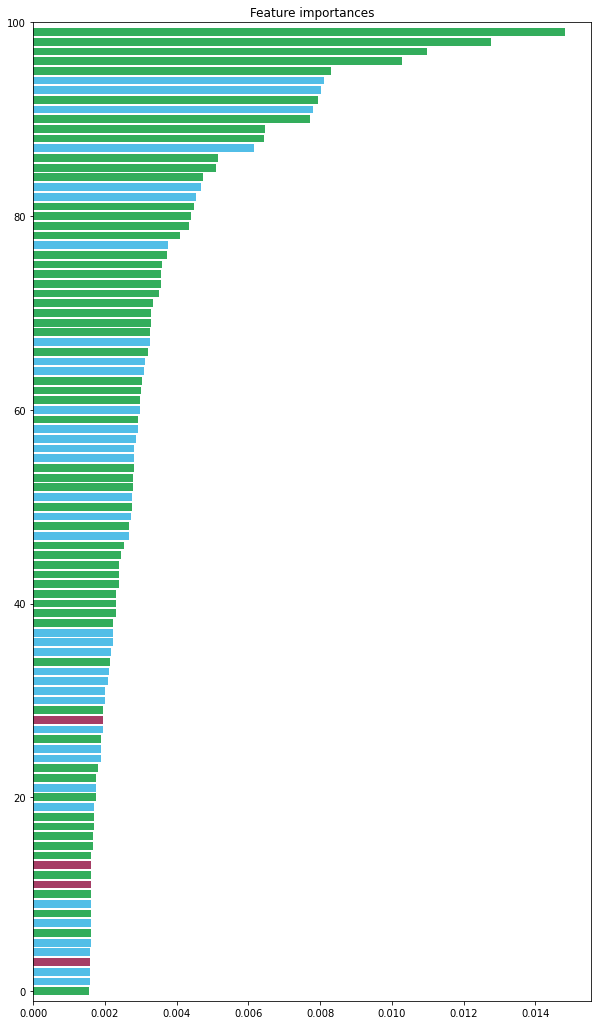

In [59]:
# Plot the feature importances of the forest
no_features = 100
plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(no_features),
    feat_importance[indices][-no_features:],
    color=colors[-no_features:],
    align="center",
    alpha=0.8,
)
plt.ylim([-1, no_features])
plt.show()

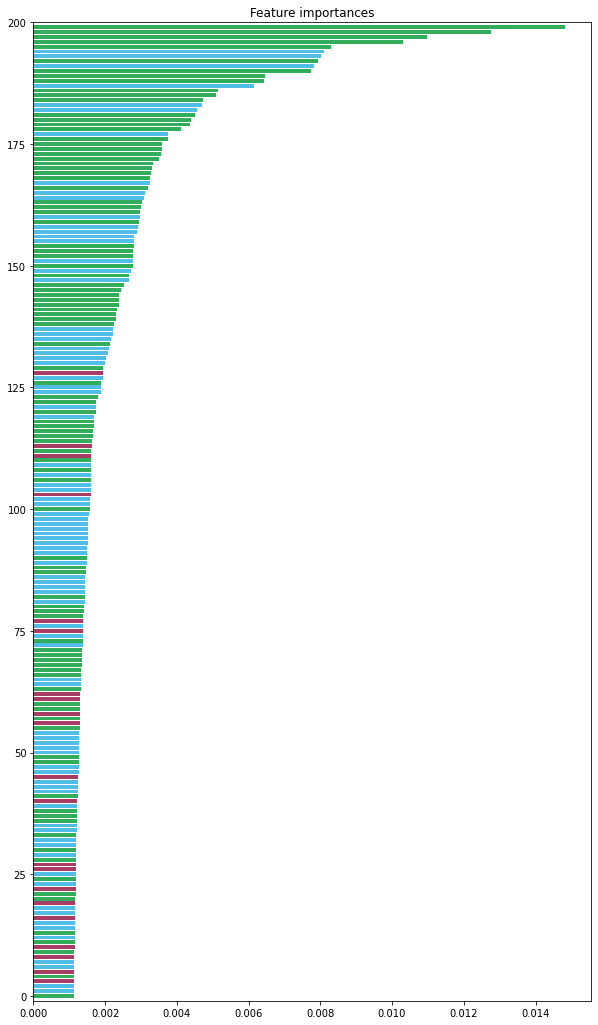

In [60]:
# Plot the feature importances of the forest
no_features = 200
plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(no_features),
    feat_importance[indices][-no_features:],
    color=colors[-no_features:],
    align="center",
    alpha=0.8,
)
plt.ylim([-1, no_features])
plt.show()

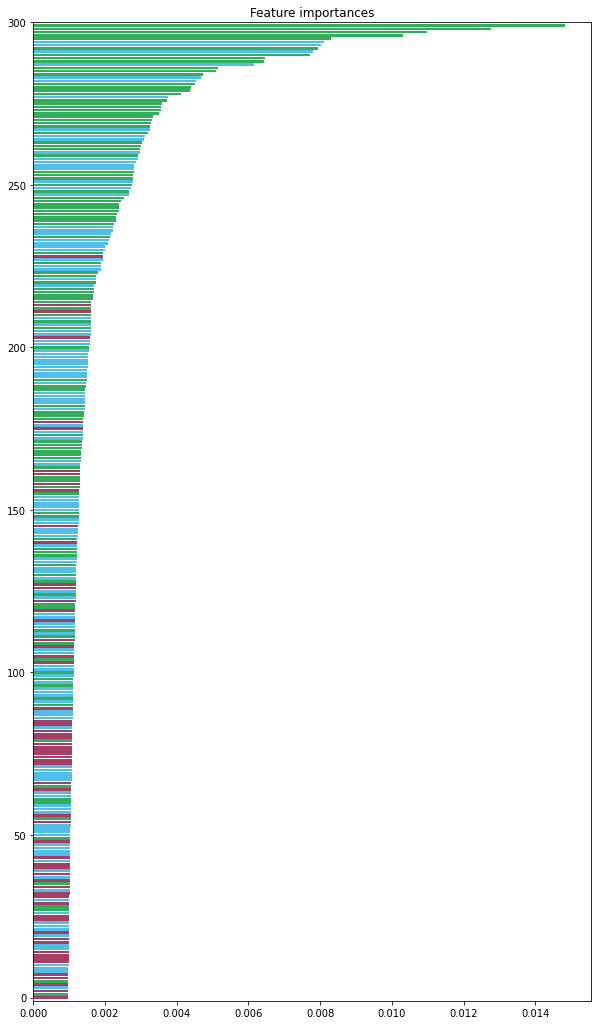

In [62]:
# Plot the feature importances of the forest
no_features = 300
plt.figure(figsize=(10, 18))
plt.title("Feature importances")
plt.barh(
    range(no_features),
    feat_importance[indices][-no_features:],
    color=colors[-no_features:],
    align="center",
    alpha=0.8,
)
plt.ylim([-1, no_features])
plt.show()

In [34]:
min(feat_importance), max(feat_importance), np.mean(feat_importance), np.median(feat_importance)

(0.00029886189502851786,
 0.014815500543307169,
 0.0011111111111111111,
 0.0008209453454902431)

In [68]:
quantile = 0.75
threshold = np.quantile(feat_importance, quantile)
topn = len(feat_importance[np.where(feat_importance > threshold)[0]])
topn_features = feat_importance[indices[-topn:]]
topn_colors = colors[-topn:]
topn_description_count = len(topn_colors[np.where(topn_colors == "#009933")[0]])
topn_requirement_count = len(topn_colors[np.where(topn_colors == "#27aee1")[0]])
topn_qualification_count = len(topn_colors[np.where(topn_colors == "#900c3f")[0]])

print(
    "There are ",
    topn,
    "/",
    len(feat_importance),
    " (~",
    100 - quantile * 100,
    "%)",
    " most important features with importance higher than ",
    round(threshold, 5),
    ", including: \n -",
    topn_description_count,
    " (~",
    round(topn_description_count * 100 / topn, 2),
    "%) features from job_description, \n -",
    topn_requirement_count,
    " (~",
    round(topn_requirement_count * 100 / topn, 2),
    "%) features from job_requirement, \n -",
    topn_qualification_count,
    " (~",
    round(topn_qualification_count * 100 / topn, 2),
    "%) features from job_qualification",
    sep="",
)

There are 225/900 (~25.0%) most important features with importance higher than 0.00108, including: 
 -101 (~44.89%) features from job_description, 
 -93 (~41.33%) features from job_requirement, 
 -31 (~13.78%) features from job_qualification


In [45]:
# # Most of importance features belong to job_description and job_requirement
# # Thus, we need remove job_qualification out of the final embeddings for skill sets
skill_feat_embeddings = skill_concat_embeddings[:, :600]
skill_feat_embeddings.shape

(361584, 600)

In [46]:
# Recreate document embeddings from selected features
emb1 = skill_concat_embeddings[:, :300]
emb2 = skill_concat_embeddings[:, 300:600]
skill_doc_embeddings = np.mean((emb1, emb2), axis=0)
skill_doc_embeddings.shape

(361584, 300)

In [47]:
# Save document embeddings for skills concatenated from selected features in numpy format file
skill_feat_embeddings_outfile = OUTPUT_DIR + "skill_feat_embeddings"
np.save(skill_feat_embeddings_outfile, skill_feat_embeddings)

In [48]:
# Save document embeddings for skills average from selected features in numpy format file
skill_doc_embeddings_outfile = OUTPUT_DIR + "skill_doc_embeddings"
np.save(skill_doc_embeddings_outfile, skill_doc_embeddings)